<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/!HW_11_12_clustering%2Bdimension_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK:**
1. **Train at least 2 clustering models.**
2. **Determine the optimal number of clusters using at least 2 metrics.**
3. **Plot the loss of information as dimensionality is reduced.**
4. **Find the optimal number of clusters and cluster assignments on the transformed dataset.**
5. **Compare the clustering of instances between the full dataset and after losing 30% of information.**
6. **Build a graph of information loss as dimensionality is reduced.**
7. **Find from the graph the number of components where no more than 30% of information is lost.**

**Dataset https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29**

In [ ]:
pip install clustergram

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_mutual_info_score,fowlkes_mallows_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from clustergram import Clustergram

from warnings import simplefilter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the dataset**

In [ ]:
# Завантажимо наш датасет
url = "/content/drive/MyDrive/Colab Notebooks/SouthGermanCredit.asc"
column_names = ["Status_of_existing_checking_account", "Duration_in_months", "Credit_history", "Purpose", "Credit_amount",
                "Savings_account", "Present_employment_since", "Installment_rate_in_percentage_of_disposable_income",
                "Personal_status_and_sex", "Other_debtors", "Present_residence_since", "Property", "Age_in_years",
                "Other_installment_plans", "Housing", "Number_of_existing_credits_at_this_bank", "Job",
                "Number_of_people_being_liable_to_provide_maintenance_for", "Telephone", "Foreign_worker", "Class"]
df = pd.read_csv(url, sep=" ", header=None, names=column_names, skiprows=1)

df.head()

Status_of_existing_checking_account  Duration_in_months  Credit_history  \
0                                    1                  18               4   
1                                    1                   9               4   
2                                    2                  12               2   
3                                    1                  12               4   
4                                    1                  12               4   

   Purpose  Credit_amount  Savings_account  Present_employment_since  \
0        2           1049                1                         2   
1        0           2799                1                         3   
2        9            841                2                         4   
3        0           2122                1                         3   
4        0           2171                1                         3   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  3     
4                                                  4     

   Personal_status_and_sex  Other_debtors  ...  Property  Age_in_years  \
0                        2              1  ...         2            21   
1                        3              1  ...         1            36   
2                        2              1  ...         1            23   
3                        3              1  ...         1            39   
4                        3              1  ...         2            38   

   Other_installment_plans  Housing  Number_of_existing_credits_at_this_bank  \
0                        3        1                                        1   
1                        3        1                                        2   
2                        3        1                                        1   
3                        3        1                                        2   
4                        1        2                                        2   

   Job  Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0    3                                                  2                 1   
1    3                                                  1                 1   
2    2                                                  2                 1   
3    2                                                  1                 1   
4    2                                                  2                 1   

   Foreign_worker  Class  
0               2      1  
1               2      1  
2               2      1  
3               1      1  
4               1      1  

[5 rows x 21 columns]

**It seems that the data is numerical. We will check this in the next step.**

In [ ]:
# На перший погляд здається, що дані числові, ми це перевіримо наступним кроком.

**So, let's take a look at the information about the dataset.**

In [ ]:
# Отже, дивимося інформацію по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   Status_of_existing_checking_account                       1000 non-null   int64
 1   Duration_in_months                                        1000 non-null   int64
 2   Credit_history                                            1000 non-null   int64
 3   Purpose                                                   1000 non-null   int64
 4   Credit_amount                                             1000 non-null   int64
 5   Savings_account                                           1000 non-null   int64
 6   Present_employment_since                                  1000 non-null   int64
 7   Installment_rate_in_percentage_of_disposable_income       1000 non-null   int64
 8   Personal_status_and_sex                

**We can see that the data is numerical. We can also say that there are no missing values.**

In [ ]:
# Бачимо, що дані числові.
# Також можемо сказати, що пропущені значення відсутні

**Let's take a look at the unique values in each column.**

In [ ]:
# Подивимось унікальні значення по кожній колонці
for column in df:
    unique_values = df[column].unique()
    print(f"Unique values in column {column}:\n{unique_values}\n")

Unique values in column Status_of_existing_checking_account:
[1 2 4 3]

Unique values in column Duration_in_months:
[18  9 12 10  8  6 24 11 30 48 36 15 42 21 27 33 28  4 47 14 39 60  5 22
 54 13 16  7 20 26 45 72 40]

Unique values in column Credit_history:
[4 2 3 0 1]

Unique values in column Purpose:
[ 2  0  9  3  1 10  5  4  6  8]

Unique values in column Credit_amount:
[ 1049  2799   841  2122  2171  2241  3398  1361  1098  3758  3905  6187
  1957  7582  1936  2647  3939  3213  2337  7228  3676  3124  2384  1424
  4716  4771   652  1154  3556  4796  3017  3535  6614  1376  1721   860
  1495  1934  3378  3868   996  1755  1028  2825  1239  1216  1258  1864
  1474  1382   640  3919  1224  2331  6313   385  1655  1053  3160  3079
  1163  2679  3578 10875  1344  1237  3077  2284  1567  2032  2745  1867
  2299   929  3399  2030  3275  1940  1602  1979  2022  3342  5866  2360
  1520  3651  2346  4454   666  1965  1995  2991  4221  1364  6361  4526
  3573  4455  2136  5954  3777   806  4

**The last column, Class, has values of 1 and 0, so it is most likely the target (True and False). The definition of the class is a credit risk, where 0 is negative and 1 is positive.**

In [ ]:
# Остання колонка Class має значення 1 і 0, тож скоріш за все це є наш таргет (True та False). В описі датасета знаходимо визначення класу, як
# кредитний ризик, де 0 - це негативний, а 1 - позитивний.

**Let's take a look at the distribution of the target.**

<Axes: xlabel='Class', ylabel='count'>

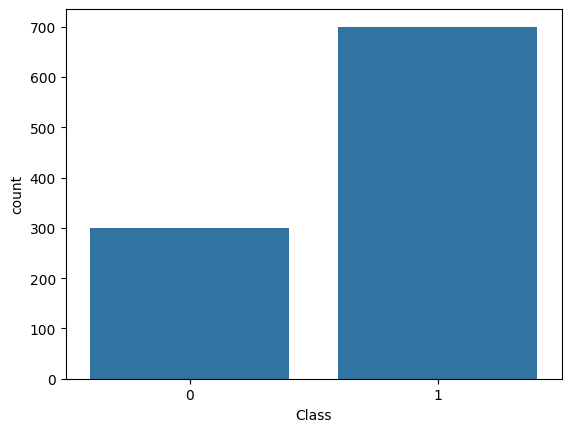

In [ ]:
# Подивимось на розподіл таргету:
sns.countplot(data=df, x="Class")

**The data is not balanced across classes, but it can be said that there are significantly more individuals with a positive credit history in this dataset than those with a negative one.**

In [ ]:
# Дані по класам не збалансовані, але можна сказати, що осіб, які мають позитивну кредитну історію в цьому датасеті значно більше
# ніж тих, в кого вона негативна.

**Let's take a look at the distribution and relationships between the features.**

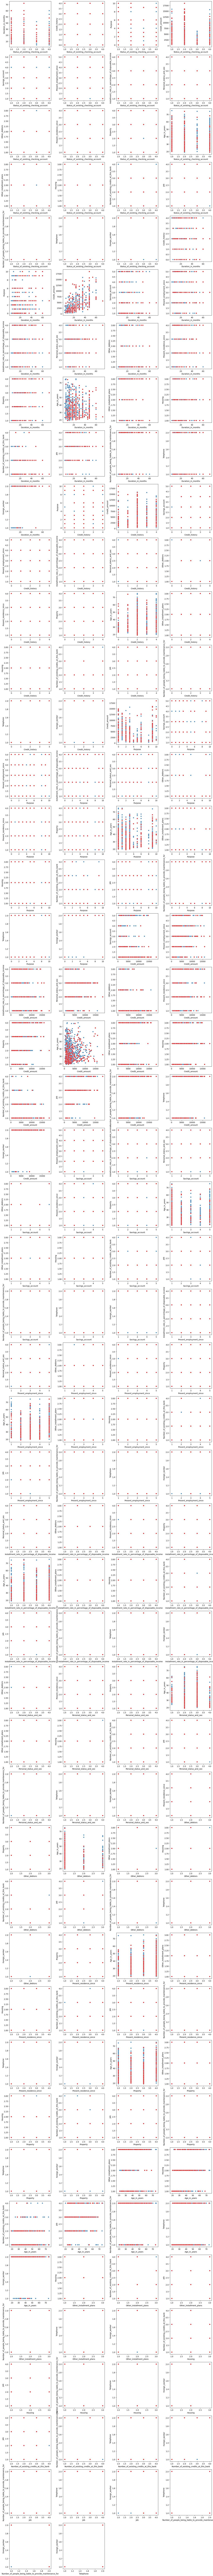

In [ ]:
# Подивимось на розподіл і взаємозв'язки між фічами
feature_combinations = list(itertools.combinations(df.columns[:-1], 2))

n_cols = 4
n_rows = (len(feature_combinations) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

for i, (feat1, feat2) in enumerate(feature_combinations):
    ax = axes.flatten()[i]
    sns.scatterplot(x=feat1, y=feat2, data=df, hue="Class", palette="Set1", ax=ax, legend=False)
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)

for i in range(len(feature_combinations), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


**It can be noted that most columns have many identical values in both classes, but their distribution is different. The features Status_of_existing_checking_account, Duration_in_months, Credit_history, Credit_amount, Age_in_years, and Purpose look interesting when considered together.**

In [ ]:
# Можна відмітити, що більшість колонок має багато однакових значеннь в обох класах, але їх розподіл різний.
# Цікавими виглядають в зв'язці одна з одною фічі Status_of_existing_checking_account, Duration_in_months,
# Credit_history, Credit_amount, Age_in_years, Purpose.

**Let's take a look at the average values by target.**

In [ ]:
# Подивимось ще середні значення по таргету
df.iloc[:, :-1].groupby(df["Class"]).mean()

Status_of_existing_checking_account  Duration_in_months  \
Class                                                            
0                                 1.903333           24.860000   
1                                 2.865714           19.207143   

       Credit_history   Purpose  Credit_amount  Savings_account  \
Class                                                             
0            2.166667  2.903333    3938.126667         1.673333   
1            2.707143  2.795714    2985.442857         2.290000   

       Present_employment_since  \
Class                             
0                      3.170000   
1                      3.475714   

       Installment_rate_in_percentage_of_disposable_income  \
Class                                                        
0                                               3.096667     
1                                               2.920000     

       Personal_status_and_sex  Other_debtors  Present_residence_since  \
Class                                                                    
0                     2.586667       1.126667                 2.850000   
1                     2.722857       1.152857                 2.842857   

       Property  Age_in_years  Other_installment_plans   Housing  \
Class                                                              
0      2.586667         33.96                 2.556667  1.913333   
1      2.260000         36.22                 2.725714  1.934286   

       Number_of_existing_credits_at_this_bank       Job  \
Class                                                      
0                                     1.366667  2.936667   
1                                     1.424286  2.890000   

       Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
Class                                                                        
0                                               1.846667          1.376667   
1                                               1.844286          1.415714   

       Foreign_worker  
Class                  
0            1.986667  
1            1.952857

**There is no significant difference between the values across classes, but we can note some columns where this difference is higher than in others, for example: Status_of_existing_checking_account, Duration_in_months, Credit_history, Credit_amount, Age_in_years. These are the same features as seen in the distribution plots, except for Purpose. Therefore, these features are likely good classifiers of the data.**

In [ ]:
# Суттєвої різниці між значеннями по класам немає, але можна відмітити деякі колонки, де ця різниця вище ніж по іншим,
# наприклад: Status_of_existing_checking_account, Duration_in_months, Credit_history, Credit_amount, Age_in_years.
# Ті ж фічі, що й на графіках розподілу, окрім Purpose.

# Тож саме ці фічі скоріш за все добре класифікують дані.

**CLUSTERING**

In [ ]:
# Переходимо до кластеризації

In [ ]:
# removing the column with class labels:
# Видаляємо колонку з мітками класів
X = df.drop("Class", axis=1)

# scaling of the features:
# Робимо обов'язкове масштабування наших фіч
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# clustering on the full set of features:
# Робимо кластеризації на повному наборі фіч:

# KMeans
kmeans_full = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_labels_full = kmeans_full.fit_predict(X_scaled)

# AgglomerativeClustering
agglomerative_full = AgglomerativeClustering(n_clusters=3)
agglomerative_labels_full = agglomerative_full.fit_predict(X_scaled)

**Then we will use the metrics silhouette_score, davies_bouldin_score, and calinski_harabasz_score to determine the optimal number of clusters for KMeans.**

In [ ]:
# Використаємо метрики silhouette_score, davies_bouldin_score, calinski_harabasz_score
# для визначення оптимальної кількості кластерів для KMeans
k_range = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

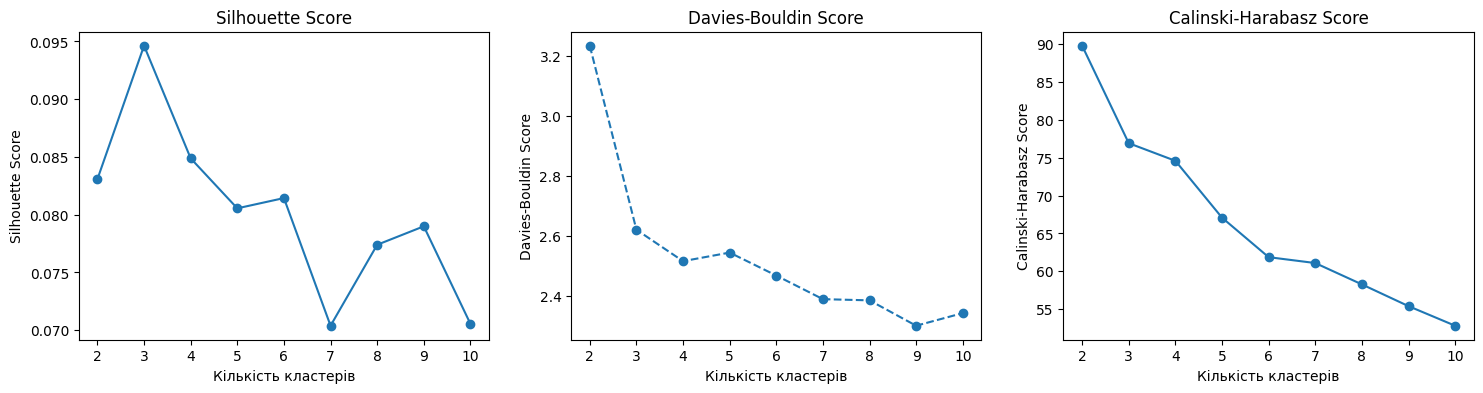

In [ ]:
# graphs for the metrics:
# Будуємо графіки по метрикам
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Кількість кластерів') # Number of clusters
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_range, davies_bouldin_scores, marker='o', linestyle='--')
plt.xlabel('Кількість кластерів') # Number of clusters
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')

plt.subplot(1, 3, 3)
plt.plot(k_range, calinski_harabasz_scores, marker='o')
plt.xlabel('Кількість кластерів') # Number of clusters
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score')

plt.show()

**All metrics indicate the optimal number of clusters is 3. Let's also look at the Clustergram.**

In [ ]:
# Усі метрики вказують на оптимальну кількість кластерів - 3. Подивимося ще на Clustergram

**There was an error related to some upcoming changes in sklearn (FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4.), so it needed to be excluded from the results.**

In [ ]:
# Виникала помилка, пов'язана з деякими майбутніми змінами в sklearn
# (FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4.),
# тож потрібно було її виключити з результатів
simplefilter(action='ignore', category=FutureWarning)

**Let's take the partitioning into 7 clusters.**

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.639 seconds.
K=3 fitted in 0.425 seconds.
K=4 fitted in 0.436 seconds.
K=5 fitted in 0.494 seconds.
K=6 fitted in 0.642 seconds.
K=7 fitted in 0.168 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

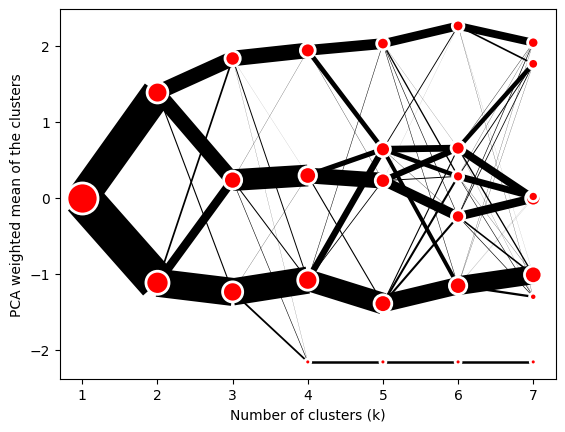

In [ ]:
# Візьмемо розбиття до 7 кластерів
cgram = Clustergram(range(1, 8))
cgram.fit(X_scaled)
cgram.plot()

**Although we specified 7 clusters, we see that some of them can be merged into the main three branches, resulting in the same 3 clusters. Therefore, we will consider 3 as the optimal number of clusters for the dataset.**

In [ ]:
# Хоч ми і задали розбиття на 7 кластерів, але бачимо, що деякі з них можна об'єднати з основними трьома гілками
# і в результаті отримаємо ті ж 3 кластери.
# Тож будемо вважати, що 3 - це все-таки оптимальна кількість кластерів для нашого датасету.

**We will use the metrics silhouette_score and davies_bouldin_score to determine the optimal number of clusters for AgglomerativeClustering.**

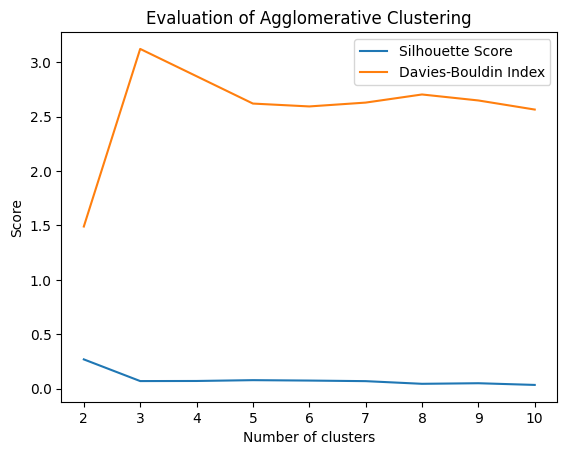

In [ ]:
# Використаємо метрики silhouette_score та davies_bouldin_score
# для визначення оптимальної кількості кластерів для AgglomerativeClustering
k_range = range(2, 11)

silhouette_scores = []
davies_bouldin_scores = []

for k in k_range:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

# building a plot for each metric:
# Будуємо графік для кожної метрики
plt.plot(k_range, silhouette_scores, label='Silhouette Score')
plt.plot(k_range, davies_bouldin_scores, label='Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Evaluation of Agglomerative Clustering')
plt.legend()
plt.show()

**Here as well, we obtained the optimal number of 3 clusters according to both metrics.**

In [ ]:
# Тут також по обом метрикам отримали оптимальну кількість 3.

**Applying the PCA method for dimensionality reduction.**

In [ ]:
# Застосовуємо метод PCA для зниження розмірності
pca = PCA(n_components=0.7)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# calculating the cumulative proportion of explained variance:
# Розраховуємо кумулятивну долю збереженої дисперсії
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

# determining the number of components that retain more than 70% of the variance:
# Знаходимо кількість компонентів, що зберігають більше 70% дисперсії
n_components_70 = np.argmax(explained_variance_ratio_cumsum >= 0.7) + 1

**Constructing a plot of information loss when reducing dimensionality.**

The number of components at which no more than 30% of information is lost: 11


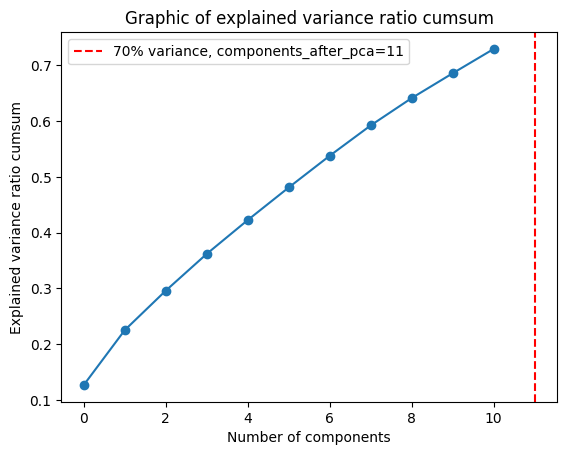

In [ ]:
# Будуємо графік втрати інформації при зменшенні розмірності.
print(f"The number of components at which no more than 30% of information is lost: {n_components_70}")
plt.plot(explained_variance_ratio_cumsum, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio cumsum")
plt.title("Graphic of explained variance ratio cumsum")
plt.axvline(n_components_70, color="r", linestyle="--", label=f"70% variance, components_after_pca={n_components_70}")
plt.legend()
plt.show()


**We have 11 components that ensure an information loss of no more than 30% after PCA.**

In [ ]:
# Маємо 11 компонентів, які гарантують втрату інформації після PCA не більше 30%

**Clustering after dimensionality reduction:**

In [ ]:
# Робимо кластеризацію після зменшення розмірності
# KMeans
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans_labels_pca = kmeans.fit_predict(X_pca)

# Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=3)
agglomerative_labels_pca = agglomerative.fit_predict(X_pca)

**Let's take a look at the labels.**

In [ ]:
# Подивимось на мітки
print("KLF", kmeans_labels_full[:30])
print("KLP", kmeans_labels_pca[:30])
print("ALF", agglomerative_labels_full[:30])
print("ALP", agglomerative_labels_pca[:30])

KLF [1 1 1 2 2 2 2 2 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0]
KLP [2 2 2 2 2 2 2 2 1 2 2 0 2 0 2 2 2 2 1 1 1 1 2 2 1 1 2 1 2 0]
ALF [0 2 0 1 1 1 1 1 2 0 2 0 0 0 0 2 2 0 2 2 2 2 0 0 2 2 0 2 0 2]
ALP [1 1 1 2 2 2 2 2 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0]


**In the first 30 points, we can see that although the number of clusters was the same, the clustering before and after PCA differs in both models.**

In [ ]:
# На перших 30 точках бачимо, що хоч кількість кластерів і була однакова, але розбиття до та після PCA в обох моделях відрізняється.

In [ ]:
# calculating the adjusted_mutual_info_score metric for the clustering results using the KMeans method:
# Рахуємо метрику adjusted_mutual_info_score для результатів кластерізації методом KMeans
amis_kmeans = adjusted_mutual_info_score(kmeans_labels_full, kmeans_labels_pca)
print("AMIS for KMeans:", amis_kmeans)

# calculating the adjusted_mutual_info_score metric for the clustering results using the AgglomerativeClustering method:
# Рахуємо метрику adjusted_mutual_info_score для результатів кластерізації методом AgglomerativeClustering
amis_agglomerative = adjusted_mutual_info_score(agglomerative_labels_full, agglomerative_labels_pca)
print("AMIS for Agglomerative Clustering:", amis_agglomerative)

AMIS for KMeans: 0.3530025600823459
AMIS for Agglomerative Clustering: 0.2201953589855571


**Therefore, the adjusted mutual info score (AMIS) for KMeans is 0.35, indicating that the clustering results using KMeans on the original data and after dimensionality reduction with PCA have a below-average level of agreement. The AMIS for AgglomerativeClustering is 0.22, suggesting a lower degree of consistency between the clustering using AgglomerativeClustering compared to KMeans.**

In [ ]:
# Отже, AMIS для KMeans дорівнює 0.35, що говорить про те, що розбиття методом KMeans на вихідних даних і
# після зменшення розмірності PCA мають рівень узгодженості менше середнього.
# AMIS для AgglomerativeClustering становить 0.22, що може вказувати на нижчий ступінь узгодженості
# між розбиттям методом AgglomerativeClustering, ніж KMeans

In [ ]:
# calculating the Fowlkes-Mallows score for the clustering results using the KMeans method:
# Рахуємо метрику fowlkes_mallows_score для результатів кластерізації методом KMeans
fms_kmeans = fowlkes_mallows_score(kmeans_labels_full, kmeans_labels_pca)
print("FMS for KMeans:", fms_kmeans)

# calculating the Fowlkes-Mallows score for the clustering results using the AgglomerativeClustering method:
# Рахуємо метрику fowlkes_mallows_score для результатів кластерізації методом AgglomerativeClustering
fms_agglomerative = fowlkes_mallows_score(agglomerative_labels_full, agglomerative_labels_pca)
print("FMS for Agglomerative Clustering:", fms_agglomerative)

FMS for KMeans: 0.6362260769914484
FMS for Agglomerative Clustering: 0.5850569100450649


**The Fowlkes-Mallows score metric performed better. The FMS score for the KMeans method, nearly 0.64, indicates that the clustering results using KMeans on the original data and after dimensionality reduction with PCA have a fairly high level of agreement. The FMS score for Agglomerative Clustering is almost 0.59, which also suggests good consistency.Therefore, based on these two metrics, it can be concluded that the clustering results with KMeans are likely slightly better than those with Agglomerative Clustering.**

In [ ]:
# Метрика fowlkes_mallows_score спрацювала краще.
# Оцінка FMS для методу KMeans майже 0.64 вказує на те, що розбиття методом KMeans на вихідних даних і
# після зменшення розмірності PCA мають достатньо високий рівень узгодженості.
# Оцінка FMS для методу Agglomerative Clustering дорівнює майже 0.59 і також свідчить про непогану узгодженість.

# Отже, на основі двох метрик, можна зробити висновок, що результати кластеризації методом KMeans, швидше за все, трохи краще,
# ніж Agglomerative Clustering.

**Let's reduce the dimensionality to 2 components.**

In [ ]:
# Зменшимо розмірність до 2 компонентів
pca = PCA(tol=0.70, n_components = 2)
XPCAreduced = pca.fit_transform(X_scaled)

**Creating a dataset with cluster labels after clustering based on PCA.**

In [ ]:
# Створюємо датасет з мітками кластерів після кластеризації на основі PCA
cluster_df = pd.DataFrame(XPCAreduced, columns=["Principal Component 1", "Principal Component 2"])
cluster_df["Cluster_K"] = kmeans_labels_pca
cluster_df["Cluster_A"] = agglomerative_labels_pca

**Creating a dataset and adding cluster labels to it.**

In [ ]:
# Створюємо датасет і додаємо туди номери наших кластерів
combined_data = pd.concat([df, cluster_df[["Cluster_K", "Cluster_A"]]], axis=1)
combined_data.head()

Status_of_existing_checking_account  Duration_in_months  Credit_history  \
0                                    1                  18               4   
1                                    1                   9               4   
2                                    2                  12               2   
3                                    1                  12               4   
4                                    1                  12               4   

   Purpose  Credit_amount  Savings_account  Present_employment_since  \
0        2           1049                1                         2   
1        0           2799                1                         3   
2        9            841                2                         4   
3        0           2122                1                         3   
4        0           2171                1                         3   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  3     
4                                                  4     

   Personal_status_and_sex  Other_debtors  ...  Other_installment_plans  \
0                        2              1  ...                        3   
1                        3              1  ...                        3   
2                        2              1  ...                        3   
3                        3              1  ...                        3   
4                        3              1  ...                        1   

   Housing  Number_of_existing_credits_at_this_bank  Job  \
0        1                                        1    3   
1        1                                        2    3   
2        1                                        1    2   
3        1                                        2    2   
4        2                                        2    2   

   Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0                                                  2                 1   
1                                                  1                 1   
2                                                  2                 1   
3                                                  1                 1   
4                                                  2                 1   

   Foreign_worker  Class  Cluster_K  Cluster_A  
0               2      1          2          1  
1               2      1          2          1  
2               2      1          2          1  
3               1      1          2          2  
4               1      1          2          2  

[5 rows x 23 columns]

**Let's take a look at the clustering splitting by values.**

In [ ]:
# Подивимось розбиття на кластери по значенням
# KMeans
combined_data["Cluster_K"].value_counts()

2    438
1    318
0    244
Name: Cluster_K, dtype: int64

In [ ]:
# AgglomerativeClustering
combined_data["Cluster_A"].value_counts()

1    568
0    345
2     87
Name: Cluster_A, dtype: int64

**We can see that in the case of KMeans, the clustering was more or less evenly distributed, whereas with AgglomerativeClustering, the 1st cluster received almost 57% of the points, approximately 35% went to cluster 0, and only 8% to cluster 2.**

In [ ]:
# Бачимо, що у випадку з KMeans розбиття пройшло більш-менш рівномірно,
# в той час як метод AgglomerativeClustering віддав 1му кластеру майже 57% точок, близько 35% - кластеру №0, і 2му лише 8%.

**Building graphs to compare KMeans clustering.**

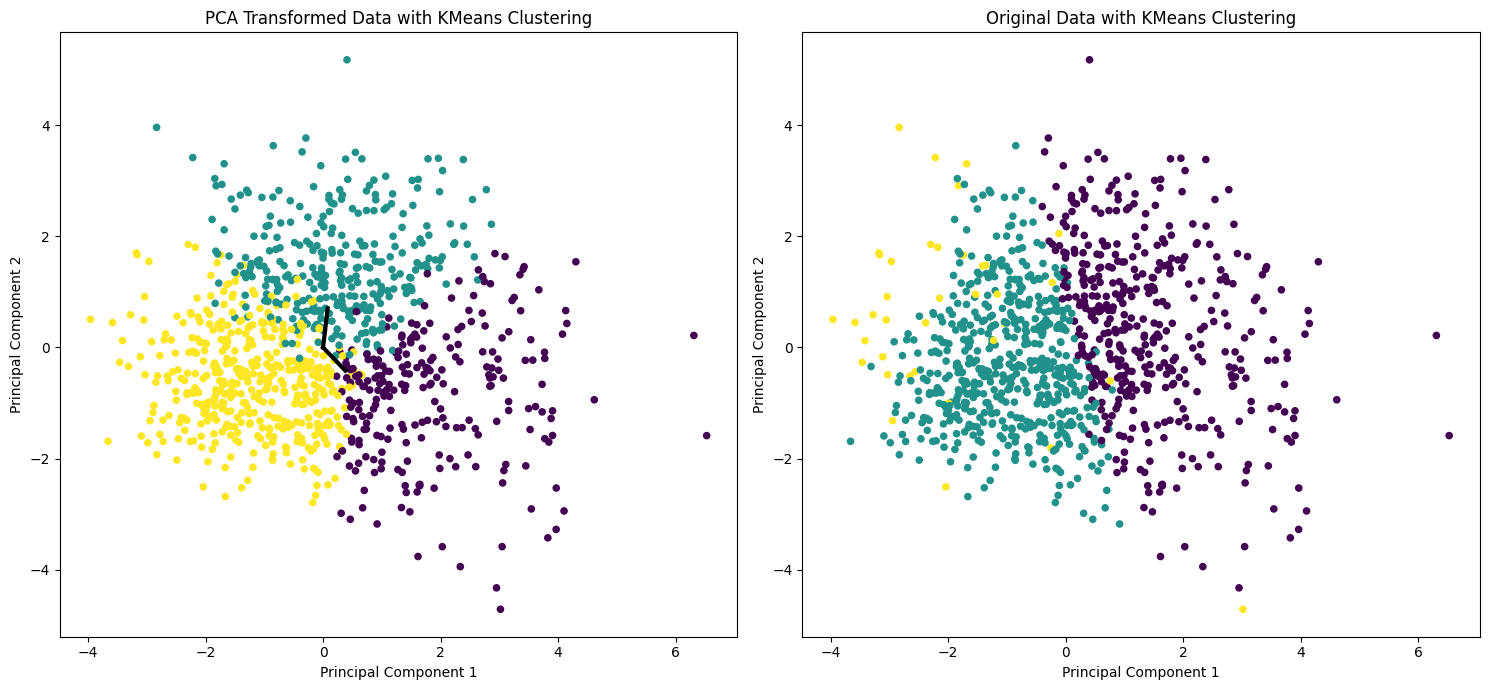

In [ ]:
# Будуємо графіки порівняння кластеризації KMeans
plt.figure(figsize=(15, 7))

# after PCA
# після PCA
plt.subplot(1, 2, 1)
plt.scatter(XPCAreduced[:,0], XPCAreduced[:,1], c=kmeans_labels_pca, s=20, cmap="viridis")
for l, v in zip(pca.explained_variance_ratio_[:2], pca.components_[:2]):
    d = 5 * np.sqrt(l) * v
    plt.plot([0, d[0]], [0, d[1]], "-k", lw=3)
plt.title("PCA Transformed Data with KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# before PCA
# до PCA
plt.subplot(1, 2, 2)
plt.scatter(XPCAreduced[:,0], XPCAreduced[:,1], c=kmeans_labels_full, s=20, cmap="viridis")
plt.title("Original Data with KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

**Building graphs to compare Agglomerative Clustering.**

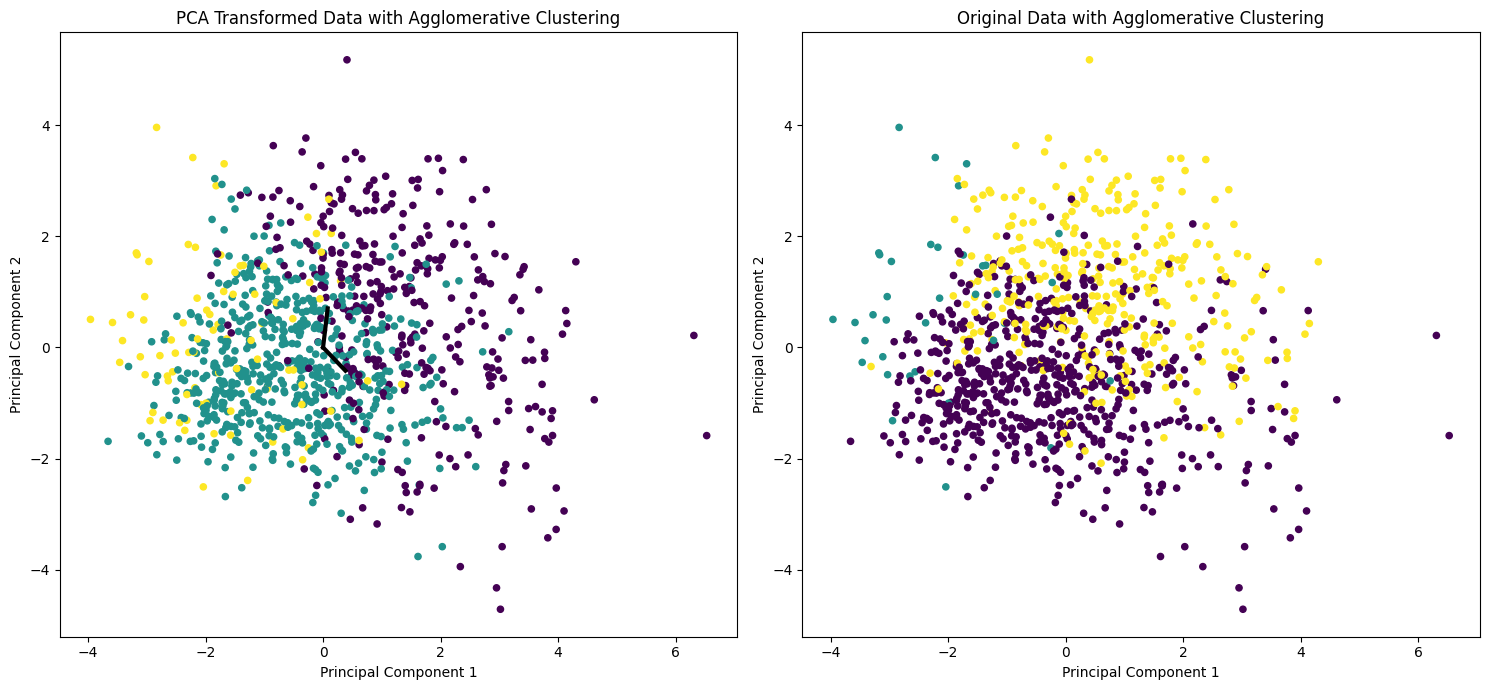

In [ ]:
# Будуємо графіки порівняння кластеризації Agglomerative Clustering
plt.figure(figsize=(15, 7))

# after PCA
# після PCA
plt.subplot(1, 2, 1)
plt.scatter(XPCAreduced[:,0], XPCAreduced[:,1], c=agglomerative_labels_pca, s=20, cmap="viridis")
for l, v in zip(pca.explained_variance_ratio_[:2], pca.components_[:2]):
    d = 5 * np.sqrt(l) * v
    plt.plot([0, d[0]], [0, d[1]], "-k", lw=3)
plt.title("PCA Transformed Data with Agglomerative Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# before PCA
# до PCA
plt.subplot(1, 2, 2)
plt.scatter(XPCAreduced[:,0], XPCAreduced[:,1], c=agglomerative_labels_full, s=20, cmap="viridis")
plt.title("Original Data with Agglomerative Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

**On the PCA Transformed Data map with Agglomerative Clustering, the deficiency in the 2nd cluster is very noticeable, as we observed in the previous step. On the Original Data map with KMeans Clustering, we see that after the initial clustering, although it also resulted in 3 clusters, the data distribution is very uneven. By the way, the Clustergram showed us as well (based on KMeans) that the distribution in terms of quantity was relatively even across the 3 clusters. Visually, we can conclude that the best clustering occurred with the KMeans method after dimensionality reduction, as we can clearly see the separation of clusters by colors, along with their uniform distribution.**

In [ ]:
# На мапі PCA Transformed Data with Agglomerative Clustering дуже добре видно нестачу 2го класу, яку ми помітили у попередньому кроці.
# На мапі Original Data with KMeans Clustering бачимо, що після першої кластеризації розбиття хоч і було також на 3 класи,
# але дані розділені дуже нерівномірно.
# До речі, той же Clustergram показував нам (якраз на основі KMeans), що розбиття по кількості +- рівномірне для 3х кластерів.

# Візуально можна зробити висновок, що найкраще розбиття відбулося методом кластеризації KMeans і після зменшення розмірності,
# так як ми краще бачимо розділення кластерів по кольорам, плюс рівномірність

**Let's take a look at the top 5 features for these two components.**

In [ ]:
# Подивимось ще на топ-5 фіч по нашим двом компонентам
top_features_pc1 = pca.components_[0].argsort()[-5:][::-1]
print("Top 5 features for Principal Component 1:")
print(df.columns[top_features_pc1])

top_features_pc2 = pca.components_[1].argsort()[-5:][::-1]
print("Top 5 features for Principal Component 2:")
print(df.columns[top_features_pc2])

Top 5 features for Principal Component 1:
Index(['Credit_amount', 'Property', 'Duration_in_months', 'Telephone', 'Job'], dtype='object')
Top 5 features for Principal Component 2:
Index(['Credit_history', 'Age_in_years',
       'Number_of_existing_credits_at_this_bank', 'Present_employment_since',
       'Status_of_existing_checking_account'],
      dtype='object')


**We can see that in the second top 5, three features (Credit_history, Age_in_years, Status_of_existing_checking_account) made it, which we noted earlier after comparing distribution plots and class-wise mean values. And in the first top 5, two features from the same list (Credit_amount, Duration_in_months) are included. Therefore, we can say that these features correlate the most with their respective principal components and make the largest contribution to their formation.**

In [ ]:
# Бачимо, що в другий ТОП-5 потрапили 3 фічі (Credit_history, Age_in_years, Status_of_existing_checking_account),
# які ми відмічали на початку після порівняння побудови графіків розподілу та виведення середніх значень по класам.
# А в перший ТОП-5 потрапили 2 фічі з того ж списку (Credit_amount, Duration_in_months).

# Отже, можна сказати, що саме ці фічі найбільше корелюють з відповідними головними компонентами і роблять найбільший внесок у їх формування.